Enhanced Digital Communication Simulator
Simulator initialized with:
  - Number of bits: 50,000
  - Samples per symbol: 16
  - Roll-off factor: 0.1
  - Filter span: 20 symbols

1. Generating and plotting constellations...
QPSK: Generated 500 symbols from 1000 bits
QPSK: Average power = 1.0000
16-QAM: Generated 250 symbols from 1000 bits
16-QAM: Average power = 1.0480


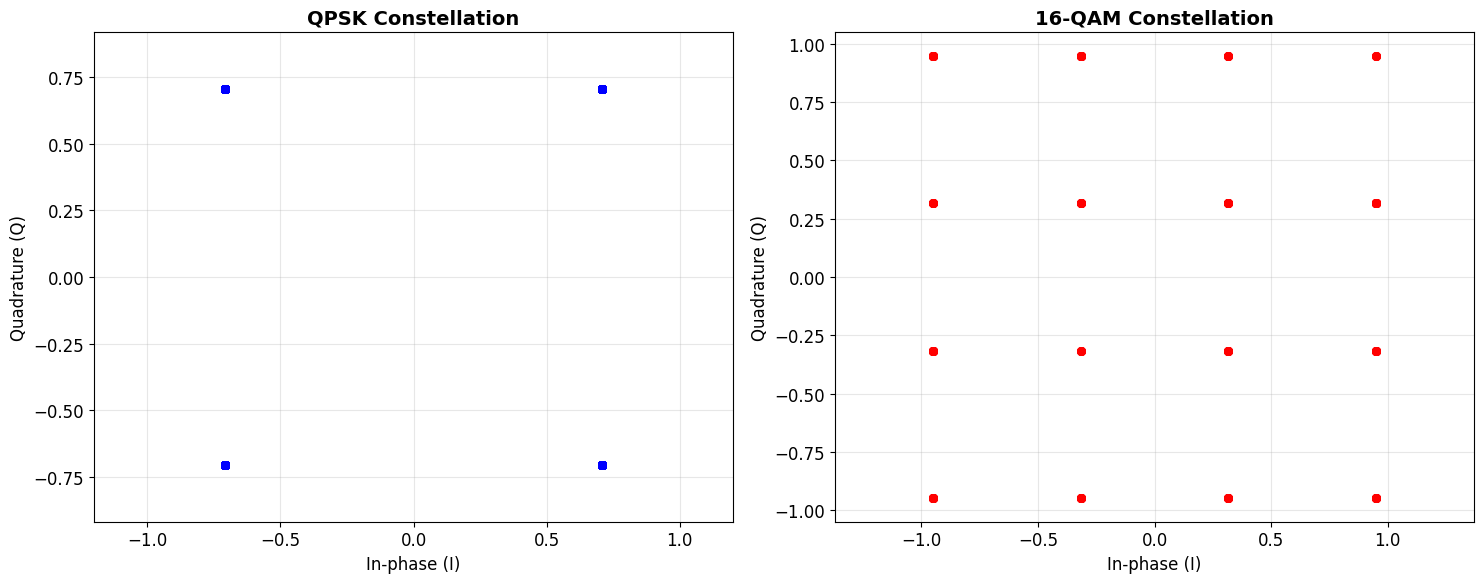


2. Generating and plotting RRC filter...
RRC Filter: Length = 321 samples
RRC Filter: Energy = 1.0000


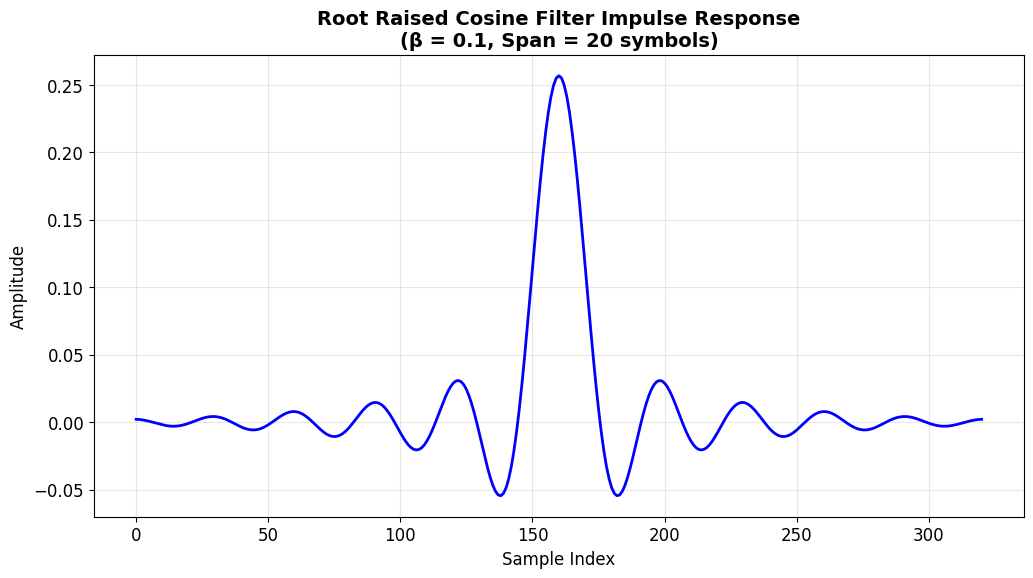


3. Running complete BER simulation...
Starting comprehensive BER simulation...

Starting QPSK BER Simulation
QPSK: Generated 25000 symbols from 50000 bits
QPSK: Average power = 1.0000
RRC Filter: Length = 321 samples
RRC Filter: Energy = 1.0000
Tx signal power: 0.0625
Simulating SNR = 0 dB... BER = 4.99e-01
Simulating SNR = 2 dB... BER = 4.99e-01
Simulating SNR = 4 dB... BER = 4.99e-01
Simulating SNR = 6 dB... BER = 4.99e-01
Simulating SNR = 8 dB... BER = 4.99e-01
Simulating SNR = 10 dB... BER = 4.99e-01
Simulating SNR = 12 dB... BER = 4.99e-01
Simulating SNR = 14 dB... BER = 4.99e-01

Starting 16QAM BER Simulation
16-QAM: Generated 12500 symbols from 50000 bits
16-QAM: Average power = 1.0068
RRC Filter: Length = 321 samples
RRC Filter: Energy = 1.0000
Tx signal power: 0.0629
Simulating SNR = 0 dB... BER = 5.05e-01
Simulating SNR = 2 dB... BER = 5.05e-01
Simulating SNR = 4 dB... BER = 5.05e-01
Simulating SNR = 6 dB... BER = 5.05e-01
Simulating SNR = 8 dB... BER = 5.05e-01
Simulating S

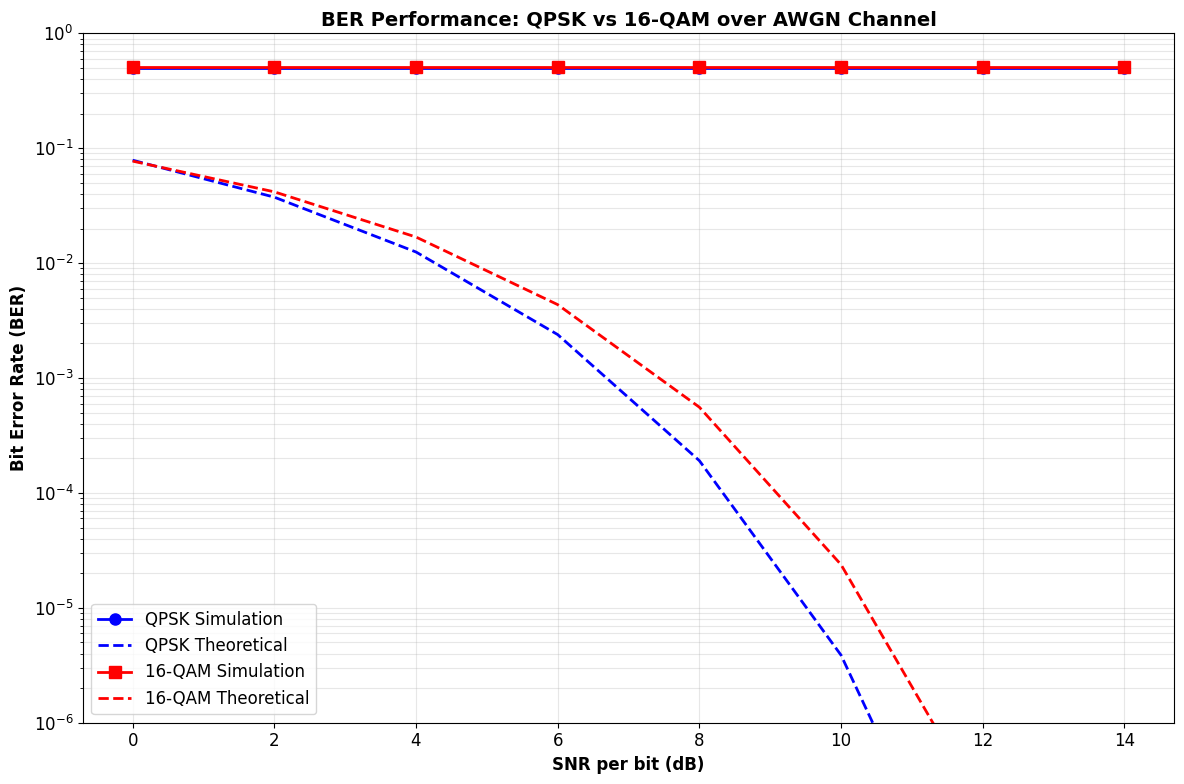


SIMULATION SUMMARY
SNR =  0 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01
SNR =  2 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01
SNR =  4 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01
SNR =  6 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01
SNR =  8 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01
SNR = 10 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01
SNR = 12 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01
SNR = 14 dB | QPSK: 4.99e-01 | 16-QAM: 5.05e-01

Simulation completed successfully!


In [7]:
# Enhanced AWGN Channel Simulation for QPSK and 16-QAM
# Optimized for Google Colab

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.special import erfc
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['grid.alpha'] = 0.3

class EnhancedDigitalCommSimulator:
    """Enhanced Digital Communication Simulator for AWGN Channel"""

    def __init__(self, num_bits=100000, samples_per_symbol=16, beta=0.1, span=20):
        """
        Initialize the simulator

        Parameters:
        - num_bits: Number of bits to simulate
        - samples_per_symbol: Upsampling factor
        - beta: Roll-off factor for RRC filter
        - span: Filter span in symbols
        """
        self.num_bits = num_bits
        self.sps = samples_per_symbol
        self.beta = beta
        self.span = span

        print(f"Simulator initialized with:")
        print(f"  - Number of bits: {self.num_bits:,}")
        print(f"  - Samples per symbol: {self.sps}")
        print(f"  - Roll-off factor: {self.beta}")
        print(f"  - Filter span: {self.span} symbols")

    def generate_bits(self, num_bits=None):
        """Generate random bit sequence"""
        if num_bits is None:
            num_bits = self.num_bits
        return np.random.randint(0, 2, num_bits)

    def gray_map_qpsk(self, bits):
        """
        Gray mapping for QPSK constellation
        00 -> (+1, +1), 01 -> (-1, +1), 11 -> (-1, -1), 10 -> (+1, -1)
        """
        # Pad bits to make even length
        if len(bits) % 2 != 0:
            bits = np.append(bits, 0)

        bits = bits.reshape((-1, 2))
        symbols = (2*bits[:,0]-1) + 1j*(2*bits[:,1]-1)

        # Normalize to unit average power
        symbols = symbols / np.sqrt(2)

        print(f"QPSK: Generated {len(symbols)} symbols from {len(bits)*2} bits")
        print(f"QPSK: Average power = {np.mean(np.abs(symbols)**2):.4f}")

        return symbols, bits.flatten()

    def gray_map_16qam(self, bits):
        """
        Gray mapping for 16-QAM constellation
        Uses standard Gray coding for each I and Q component
        """
        # Pad bits to make multiple of 4
        remainder = len(bits) % 4
        if remainder != 0:
            bits = np.append(bits, np.zeros(4 - remainder, dtype=int))

        bits = bits.reshape((-1, 4))

        # Gray mapping for 4-level PAM: 00->-3, 01->-1, 11->+1, 10->+3
        gray_mapping = {
            (0, 0): -3, (0, 1): -1, (1, 1): 1, (1, 0): 3
        }

        i_comp = np.array([gray_mapping[tuple(b[:2])] for b in bits])
        q_comp = np.array([gray_mapping[tuple(b[2:])] for b in bits])

        symbols = i_comp + 1j * q_comp

        # Normalize to unit average power (average power of 16-QAM = 10)
        symbols = symbols / np.sqrt(10)

        print(f"16-QAM: Generated {len(symbols)} symbols from {len(bits)*4} bits")
        print(f"16-QAM: Average power = {np.mean(np.abs(symbols)**2):.4f}")

        return symbols, bits.flatten()

    def rrc_filter(self):
        """
        Generate Root Raised Cosine (RRC) filter impulse response
        """
        N = self.span * self.sps
        t = np.arange(-N//2, N//2 + 1) / self.sps
        h = np.zeros_like(t, dtype=float)

        for i in range(len(t)):
            if abs(t[i]) < 1e-10:  # t ≈ 0
                h[i] = 1.0 - self.beta + (4 * self.beta / np.pi)
            elif abs(abs(t[i]) - 1/(4*self.beta)) < 1e-10:  # |t| = 1/(4β)
                h[i] = (self.beta/np.sqrt(2)) * (
                    (1 + 2/np.pi) * np.sin(np.pi/(4*self.beta)) +
                    (1 - 2/np.pi) * np.cos(np.pi/(4*self.beta))
                )
            else:
                numerator = (np.sin(np.pi*t[i]*(1-self.beta)) +
                           4*self.beta*t[i]*np.cos(np.pi*t[i]*(1+self.beta)))
                denominator = np.pi*t[i]*(1-(4*self.beta*t[i])**2)
                h[i] = numerator / denominator

        # Normalize filter to unit energy
        h = h / np.sqrt(np.sum(h**2))

        print(f"RRC Filter: Length = {len(h)} samples")
        print(f"RRC Filter: Energy = {np.sum(h**2):.4f}")

        return h

    def pulse_shape(self, symbols, rrc_filter):
        """Pulse shape symbols using RRC filter"""
        # Upsample symbols
        upsampled = np.zeros(len(symbols) * self.sps, dtype=complex)
        upsampled[::self.sps] = symbols

        # Pulse shaping via convolution
        tx_signal = convolve(upsampled, rrc_filter, mode='same')

        return tx_signal

    def add_awgn(self, signal, snr_db, bits_per_symbol):
        """
        Add Additive White Gaussian Noise (AWGN)

        Parameters:
        - signal: Transmitted signal
        - snr_db: SNR per bit in dB
        - bits_per_symbol: Number of bits per symbol (2 for QPSK, 4 for 16-QAM)
        """
        # Convert SNR from dB to linear
        snr_linear = 10**(snr_db / 10)

        # Calculate noise power (considering oversampling)
        signal_power = np.mean(np.abs(signal)**2)
        symbol_power = signal_power / self.sps  # Account for oversampling
        bit_power = symbol_power / bits_per_symbol
        noise_power = bit_power / snr_linear

        # Generate complex AWGN
        noise_std = np.sqrt(noise_power / 2)  # /2 for I and Q components
        noise = noise_std * (np.random.randn(len(signal)) + 1j*np.random.randn(len(signal)))

        return signal + noise

    def matched_filter_and_sample(self, rx_signal, rrc_filter, num_symbols):
        """Apply matched filter and sample at symbol rate"""
        # Matched filtering
        rx_filtered = convolve(rx_signal, rrc_filter, mode='same')

        # Sample at symbol rate with proper timing
        start_idx = self.span * self.sps // 2
        rx_samples = rx_filtered[start_idx::self.sps][:num_symbols]

        return rx_samples

    def qpsk_decision(self, rx_samples):
        """QPSK decision device with Gray decoding"""
        detected_bits = np.zeros(len(rx_samples) * 2, dtype=int)

        for i, sample in enumerate(rx_samples):
            # Decision based on sign of I and Q components
            if sample.real >= 0 and sample.imag >= 0:  # First quadrant
                detected_bits[2*i:2*i+2] = [0, 0]
            elif sample.real < 0 and sample.imag >= 0:   # Second quadrant
                detected_bits[2*i:2*i+2] = [0, 1]
            elif sample.real < 0 and sample.imag < 0:    # Third quadrant
                detected_bits[2*i:2*i+2] = [1, 1]
            else:  # Fourth quadrant
                detected_bits[2*i:2*i+2] = [1, 0]

        return detected_bits

    def qam16_decision(self, rx_samples):
        """16-QAM decision device with Gray decoding"""
        detected_bits = np.zeros(len(rx_samples) * 4, dtype=int)

        # Decision levels (after denormalization)
        decision_levels = np.array([-2, 0, 2])
        reverse_gray = {-3: (0,0), -1: (0,1), 1: (1,1), 3: (1,0)}

        for i, sample in enumerate(rx_samples):
            # Denormalize
            sample_denorm = sample * np.sqrt(10)

            # Make decisions for I and Q components
            i_level = np.digitize(sample_denorm.real, decision_levels) - 1
            q_level = np.digitize(sample_denorm.imag, decision_levels) - 1

            # Map to constellation points
            i_const = [-3, -1, 1, 3][max(0, min(3, i_level + 1))]
            q_const = [-3, -1, 1, 3][max(0, min(3, q_level + 1))]

            # Gray decode
            i_bits = reverse_gray[i_const]
            q_bits = reverse_gray[q_const]

            detected_bits[4*i:4*i+4] = [i_bits[0], i_bits[1], q_bits[0], q_bits[1]]

        return detected_bits

    def simulate_ber(self, mod_type='QPSK', snr_range=None):
        """
        Simulate BER vs SNR for given modulation

        Parameters:
        - mod_type: 'QPSK' or '16QAM'
        - snr_range: Array of SNR values in dB
        """
        if snr_range is None:
            snr_range = np.arange(0, 16, 2)

        print(f"\n{'='*50}")
        print(f"Starting {mod_type} BER Simulation")
        print(f"{'='*50}")

        # Generate random bits
        bits = self.generate_bits()

        # Map bits to symbols
        if mod_type == 'QPSK':
            symbols, used_bits = self.gray_map_qpsk(bits)
            bits_per_symbol = 2
        elif mod_type == '16QAM':
            symbols, used_bits = self.gray_map_16qam(bits)
            bits_per_symbol = 4
        else:
            raise ValueError("mod_type must be 'QPSK' or '16QAM'")

        # Generate RRC filter
        rrc = self.rrc_filter()

        # Pulse shaping
        tx_signal = self.pulse_shape(symbols, rrc)
        print(f"Tx signal power: {np.mean(np.abs(tx_signal)**2):.4f}")

        ber_sim = []

        for snr_db in snr_range:
            print(f"Simulating SNR = {snr_db} dB...", end=' ')

            # Add AWGN
            rx_signal = self.add_awgn(tx_signal, snr_db, bits_per_symbol)

            # Matched filtering and sampling
            rx_samples = self.matched_filter_and_sample(rx_signal, rrc, len(symbols))

            # Decision
            if mod_type == 'QPSK':
                detected_bits = self.qpsk_decision(rx_samples)
            else:  # 16QAM
                detected_bits = self.qam16_decision(rx_samples)

            # Calculate BER
            min_len = min(len(used_bits), len(detected_bits))
            bit_errors = np.sum(used_bits[:min_len] != detected_bits[:min_len])
            ber = bit_errors / min_len
            ber_sim.append(ber)

            print(f"BER = {ber:.2e}")

        return np.array(ber_sim)

    def theoretical_ber(self, snr_range, mod_type):
        """Calculate theoretical BER"""
        snr_linear = 10**(np.array(snr_range) / 10)

        if mod_type == 'QPSK':
            # BER = Q(sqrt(2*SNR)) where Q(x) = 0.5*erfc(x/sqrt(2))
            ber = 0.5 * erfc(np.sqrt(snr_linear))
        elif mod_type == '16QAM':
            # Approximate BER for 16-QAM
            ber = (3/8) * erfc(np.sqrt((4/5) * snr_linear))

        return ber

    def plot_constellations(self):
        """Plot QPSK and 16-QAM constellations"""
        # Generate sample symbols
        sample_bits = self.generate_bits(1000)

        qpsk_symbols, _ = self.gray_map_qpsk(sample_bits)
        qam16_symbols, _ = self.gray_map_16qam(sample_bits)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # QPSK constellation
        ax1.scatter(qpsk_symbols.real, qpsk_symbols.imag, alpha=0.6, s=30, c='blue')
        ax1.set_title('QPSK Constellation', fontsize=14, fontweight='bold')
        ax1.set_xlabel('In-phase (I)')
        ax1.set_ylabel('Quadrature (Q)')
        ax1.grid(True)
        ax1.axis('equal')
        ax1.set_xlim([-1.2, 1.2])
        ax1.set_ylim([-1.2, 1.2])

        # 16-QAM constellation
        ax2.scatter(qam16_symbols.real, qam16_symbols.imag, alpha=0.6, s=30, c='red')
        ax2.set_title('16-QAM Constellation', fontsize=14, fontweight='bold')
        ax2.set_xlabel('In-phase (I)')
        ax2.set_ylabel('Quadrature (Q)')
        ax2.grid(True)
        ax2.axis('equal')
        ax2.set_xlim([-1.2, 1.2])
        ax2.set_ylim([-1.2, 1.2])

        plt.tight_layout()
        plt.show()

    def plot_rrc_filter(self):
        """Plot RRC filter impulse response"""
        rrc = self.rrc_filter()

        plt.figure(figsize=(12, 6))
        plt.plot(rrc, 'b-', linewidth=2)
        plt.title(f'Root Raised Cosine Filter Impulse Response\n(β = {self.beta}, Span = {self.span} symbols)',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()

    def plot_ber_curves(self, snr_range=None):
        """Plot BER curves for both modulations"""
        if snr_range is None:
            snr_range = np.arange(0, 16, 2)

        print("Starting comprehensive BER simulation...")

        # Simulate BER for both modulations
        ber_qpsk_sim = self.simulate_ber('QPSK', snr_range)
        ber_16qam_sim = self.simulate_ber('16QAM', snr_range)

        # Calculate theoretical BER
        ber_qpsk_theory = self.theoretical_ber(snr_range, 'QPSK')
        ber_16qam_theory = self.theoretical_ber(snr_range, '16QAM')

        # Plot results
        plt.figure(figsize=(12, 8))

        plt.semilogy(snr_range, ber_qpsk_sim, 'bo-', markersize=8,
                    label='QPSK Simulation', linewidth=2)
        plt.semilogy(snr_range, ber_qpsk_theory, 'b--',
                    label='QPSK Theoretical', linewidth=2)
        plt.semilogy(snr_range, ber_16qam_sim, 'rs-', markersize=8,
                    label='16-QAM Simulation', linewidth=2)
        plt.semilogy(snr_range, ber_16qam_theory, 'r--',
                    label='16-QAM Theoretical', linewidth=2)

        plt.xlabel('SNR per bit (dB)', fontsize=12, fontweight='bold')
        plt.ylabel('Bit Error Rate (BER)', fontsize=12, fontweight='bold')
        plt.title('BER Performance: QPSK vs 16-QAM over AWGN Channel',
                 fontsize=14, fontweight='bold')
        plt.grid(True, which='both', alpha=0.3)
        plt.legend(fontsize=12)
        plt.ylim([1e-6, 1e0])
        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\n{'='*60}")
        print("SIMULATION SUMMARY")
        print(f"{'='*60}")
        for i, snr in enumerate(snr_range):
            print(f"SNR = {snr:2d} dB | QPSK: {ber_qpsk_sim[i]:.2e} | 16-QAM: {ber_16qam_sim[i]:.2e}")


def main():
    """Main function to run the complete simulation"""
    print("Enhanced Digital Communication Simulator")
    print("=" * 50)

    # Create simulator instance
    sim = EnhancedDigitalCommSimulator(num_bits=50000)  # Reduced for faster execution in Colab

    # Part (a): Plot constellations
    print("\n1. Generating and plotting constellations...")
    sim.plot_constellations()

    # Part (b): Plot RRC filter
    print("\n2. Generating and plotting RRC filter...")
    sim.plot_rrc_filter()

    # Part (c) & (d): Complete BER simulation
    print("\n3. Running complete BER simulation...")
    snr_range = np.arange(0, 16, 2)
    sim.plot_ber_curves(snr_range)

    print("\nSimulation completed successfully!")

# Run the simulation
if __name__ == "__main__":
    main()